<center>
<a href="https://www.vision.rwth-aachen.de/">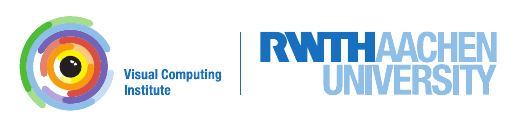</a>
</center>

# Advanced Machine Learning Excercises

**Assistants:**
<br>
Alexey Nekrasov &lt;nekrasov@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **NOT** mandatory, but we still encourage you to work on them, in order to gain a deeper understanding.

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:
Before submission remove outputs from the notebooks to prevent sending large files.
With images a hundred submissions could occupy a few GB of space.
To erase the outputs before submission, use a tool [nbstripout](https://github.com/kynan/nbstripout).

Upload all the notebook files with your changes to moodle. **IMPORTANT**: Do not rename files.

⏰ Due date: -

# Exercise 4: Generative Adverserial Networks and Auto Encoders

### Task:
1. Build an autoencoder and train the model on MNIST dataset. Also visualize the reconstructed images and the latent space embedding.
2. Add noise to the input data and adapt the autoencoder to a denoising autoencoder.
3. Adapt the autoencoder to a variational autoencoder.

### Running notebooks on Google Colaboratory

* Goto [Google Colab](https://colab.research.google.com/)  
* Under `File` menu, click on `Upload notebook` and upload this notebook.  
* To run the notebook with GPU, click on `Runtime` menu, select `Change runtime type`, and select `GPU` as Hardware accelerator.  
  
Note:  
* If you see a `“RuntimeError: CUDA error: device-side assert triggered”` error, try running the notebook on CPU (by choosing `None` in Hardware accelerator as discussed above) to get a more detailed traceback for the error.  
* If the notebook is running fine with CPU and the same error persists while using GPU, try restarting the runtime.

## Normal Auto Encoder

Install the needed packages in the current Jupyter kernel.

In [ ]:
# import sys
#
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install -U scikit-learn
# !{sys.executable} -m pip install tqdm

PyTorch is an open source python package for building deep learning models. We will use this package in this exercise. For a basic understanding of the package, see [PyTorch introduction](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch import optim
from torch.autograd import Variable
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set a random seed for reproducibility

In [2]:
seed = 12
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


Use GPU if available to accelerate training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define the transformations needed on the input data

PyTorch has two primitives to work with data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the  data samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.  
The `torchvision.datasets` module contains Dataset objects for many real-world vision data. We will use the MNIST dataset of handwritten digits in this exercise.  
Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the data samples and labels respectively. You can use `torchvision.transforms.Compose` to compose multiple transformations together.  
For our MNIST dataset, we can use the `torchvision.transforms.ToTensor` to convert the numpy array to a tensor and we will define a function to flatten the tensor to a 1D input using `torch.flatten`. `torchvision.transforms.Lambda` allows us to define any user defined transformations.

In [4]:
# Creating the transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(torch.flatten),
    ]
)

Download the MNIST dataset and define the training and testing sets by applying the previously defined transformations.

In [5]:
# Define the train and test sets from MNIST data
dset_train = MNIST("./data", train=True, transform=transform, download=True)
dset_test = MNIST("./data", train=False, transform=transform, download=True)

### Define the dataloaders

Here we define a batch size for the dataloader, i.e. each element in the dataloader iterable will return a batch of features and labels. Additionally, we can shuffle the data in each epoch.

In [6]:
batch_size = 64

# We use DataLoader to get the images of the training set batch by batch.
train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=True)

### Plotting the dataset

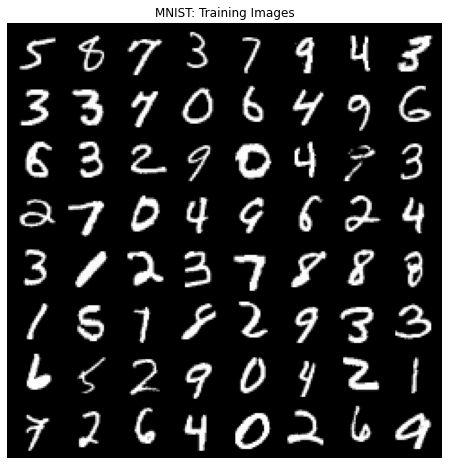

Labels:
[[5 8 7 3 7 9 4 3]
 [3 3 7 0 6 4 9 6]
 [6 3 2 9 0 4 9 3]
 [2 7 0 4 9 6 2 4]
 [3 1 2 3 7 8 8 8]
 [1 5 7 8 2 9 3 3]
 [6 5 2 9 0 4 2 1]
 [7 2 6 4 0 2 6 9]]


In [7]:
# Plot a few MNIST examples

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))
images = make_grid(
    images.view(batch_size, 1, 28, 28),
    padding=2,
    normalize=True,
).cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("MNIST: Training Images")
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.show()

print("Labels:")
print(labels.reshape(-1, 8).numpy())

### Construct a class for autoencoder

Define an autoencoder class with the following dimensions for the hidden layers:  
**Encoder:** $\left[256, 128\right]$  
**Latent dimension:** To be specified by user at the time of initialization  
**Decoder:** $\left[128, 256\right]$ 

Please refer [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for defining the encoder and decoder. 
The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [9]:
# Define size of input image features
# For MNIST data, we flatten the 28x28 image
num_input_features = 28**2


class AutoEncoder(nn.Module):
    def __init__(self, num_latent_features):
        super().__init__()

        self.num_latent_features = num_latent_features
        # Define encoder network to encode the data onto the latent space using two linear layers.
        # self.encoder = ...
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            # Input layer
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            # 1st hidden layer
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # Latent layer
            nn.Linear(in_features=128, out_features=self.num_latent_features),
        )
        # raise NotImplementedError()

        # Define decoder network to decode the latent information into the original image.
        # self.decoder = ...
        # YOUR CODE HERE
        self.decoder = nn.Sequential(
            # 1st hidden layer
            nn.Linear(in_features=self.num_latent_features, out_features=128),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            # Output layer
            nn.Linear(in_features=256, out_features=num_input_features),
            # The inputs are greyscale images with values on the scale [0, 1]
            # Convert the output to the scale
            nn.Sigmoid(),
        )
        # raise NotImplementedError()

    def forward(self, x):
        outputs = {}

        # Pass the input through encoder to get the latent representation
        z = self.encoder(x)

        # Pass the latent information through decoder to reconstruct the input
        x = self.decoder(z)

        # Return both the latent representation and output reconstruction
        outputs["x_out"] = x
        outputs["z"] = z

        return outputs

Initialize the model with a latent dimension of 10.   
You can also print the model to see the general structure.

In [10]:
num_latent_features = 10
model = AutoEncoder(num_latent_features).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Define the loss function and optimizer 

Define a loss function including L1 regularization on latent representation. The weightage of regularization in the total loss is to be controlled.  
Also define an optimizer for updating the parameter weights.

In [11]:
def ae_loss(x_recons, x):
    """
    Loss function for the autoencoder with an additional l1 regularization.

    Parameters
    ----------
    x_recons : array_like
        Decoder output.
    x : array_like
        Input to the encoder.

    Returns
    -------
    loss : float
        resulting autoencoder loss.
    """
    # YOUR CODE HERE
    return mse_loss(x_recons, x)
    # raise NotImplementedError()


lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = ae_loss

### Train the auto encoder

Each module inherited from `nn.Module` has a `self.training` attribute which should be set to `True` while training and `False` while testing. You can use the `train()` function to set the model in taining mode and `eval()` function to set the model in testing mode. This is needed because some layers (like batch normalization, droput, etc.) behaves differently while training and testing.  

**Perform the following steps while training the model:**  
* Iterate over batches of input data in each epoch.
* PyTorch accumulates the parameter gradients on each subsequent backward pass, thus we need to set the gradients explicitly to zero in each iteration to avoid this. This can be done by calling function `zero_grad()` on the optimizer.
* Perform a forward pass in the model with the input batch.
* Calculate the loss for this batch of input.
* Calculate the gradients for the model parameters in the direction of minimizing the loss. The `backward()` function is used on the loss to calculate this gradients.
* Perform the optimization of model parameters using the gradients. The `step()` function is used on the optimizer to update the parameters.

The batch loss and/or epoch loss can be printed out to visualize the training progress.  

**Perform the following while testing the model:** 
* Set the model to testing mode.
* Disable the gradient calculation. Take a look at [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html).
* Calculate the test set loss.

When using a tensor for operations that does not require gradient calculations (for debugging, plotting, etc.), you need to break it from the computational graph. This can be done by calling the `detach()` function on the tensor. A tensor on GPU can be moved to CPU by calling the `cpu()` function on the tensor.

⚠️ The training can take a long time, from minutes to half an hour or even more, depending on your hardware!

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 0.0006 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


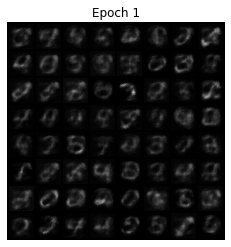

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


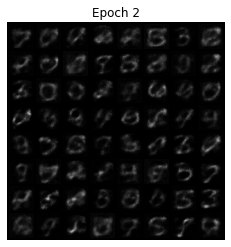

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


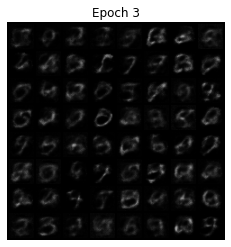

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


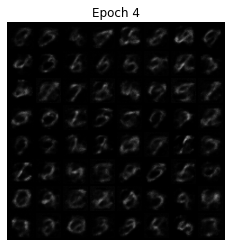

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


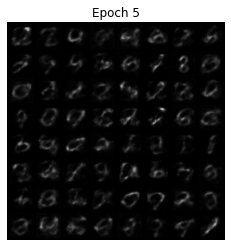

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


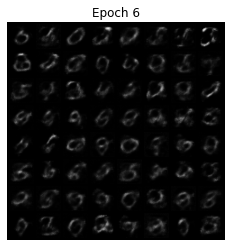

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


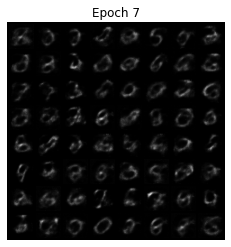

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


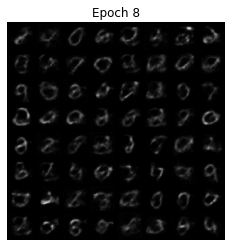

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


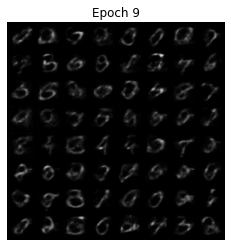

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


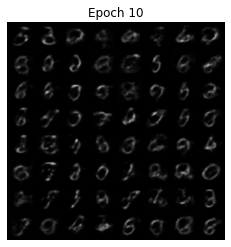

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


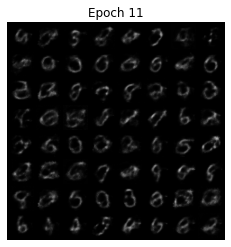

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


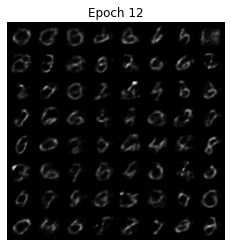

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


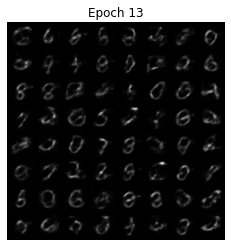

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


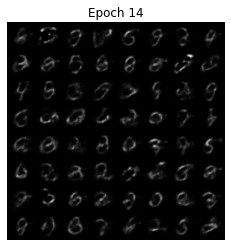

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


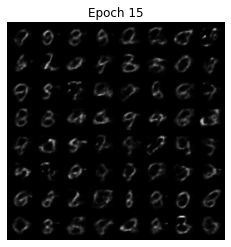

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


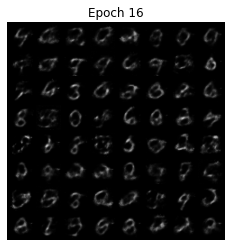

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


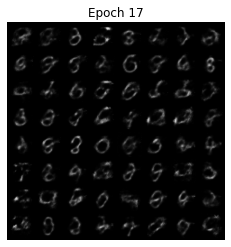

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


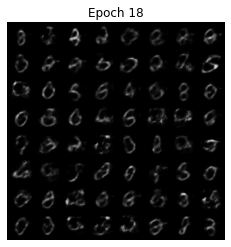

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


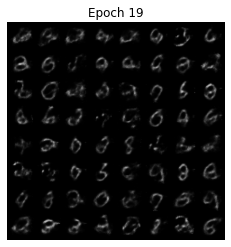

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


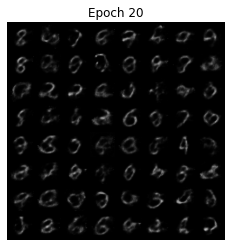

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


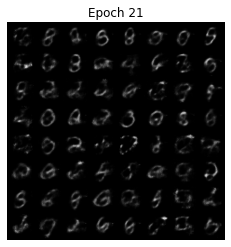

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


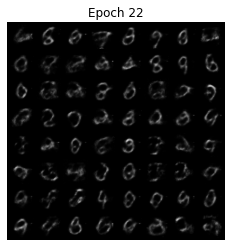

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


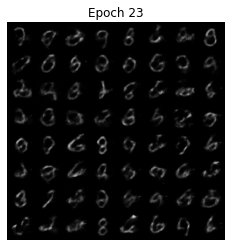

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


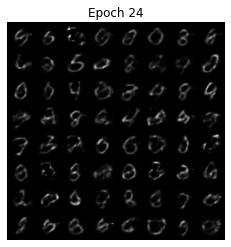

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 0.0002 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0002 =======


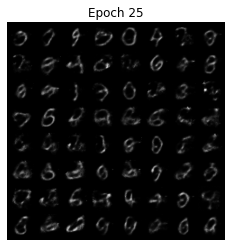

In [12]:
epochs = 25

train_loss_list = []
test_loss_list = []

for epoch in range(1, epochs + 1):
    ### =====TRAINING=====
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")
            data = data.to(device)

            """
            Calculate the loss for the current batch of inputs and 
            optimize the network parameters using the gradients.
            Variable `loss` should hold the loss value for current batch which 
            will be used to display the progress of training.
            """
            # loss = ...
            # YOUR CODE HERE
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_function(outputs["x_out"], data)
            loss.backward()
            optimizer.step()
            # raise NotImplementedError()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )
        train_loss_list.append(avg_epoch_loss)

    ### =====TESTING=====
    model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                """
                Calculate the loss for the current test batch of inputs.
                Variable `loss` should hold the test set loss value for current batch which 
                will be used to display the progress of training.
                """
                # test_loss = ...
                # YOUR CODE HERE
                outputs = model(data)
                loss = loss_function(outputs["x_out"], data)
                test_loss += loss.item()
                # raise NotImplementedError()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")
    test_loss_list.append(test_loss)

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

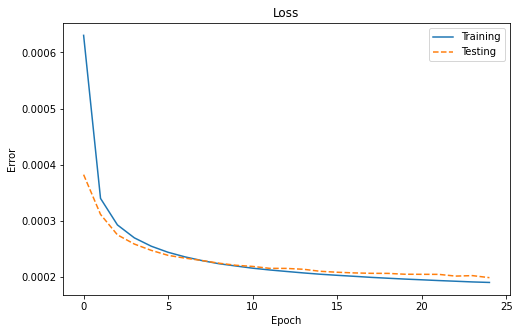

In [13]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(8, 5))

# Loss
ax = axarr
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

ax.plot(np.arange(epochs), train_loss_list)
ax.plot(np.arange(epochs), test_loss_list, linestyle="--")
ax.legend(["Training", "Testing"])

### Visualizing input data and its reconstruction from the trained model

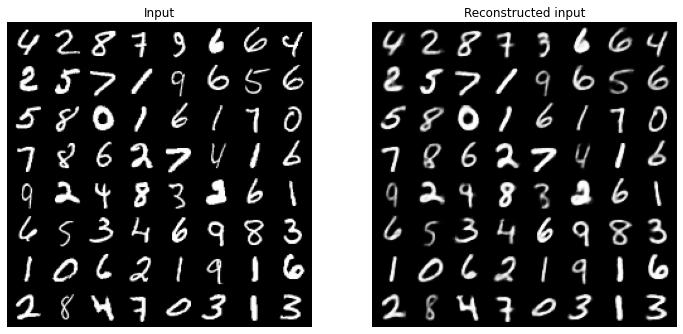

In [14]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

### Visualize the latent space embeddings

The latent space embedding can be visualized by projecting into 2D space using [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [15]:
def generate_visualisation(latent, labels):
    latent_embedded = TSNE(
        n_components=2, init="random", learning_rate="auto"
    ).fit_transform(latent)
    N = 10
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_embedded[:, 0],
        latent_embedded[:, 1],
        c=labels,
        marker="o",
        edgecolor="none",
        cmap="Spectral",
    )
    plt.colorbar(boundaries=np.arange(N + 1) - 0.5).set_ticks(np.arange(N))
    plt.grid(True)


def visualize_embeddings(model, train_dataloader):
    with torch.no_grad():
        x, labels = next(iter(train_dataloader))
        x = Variable(x)
        x = x.to(device)
        outputs = model(x)
        z = outputs["z"].cpu()
        generate_visualisation(z, labels)

To generate a nice plot, we need sufficient amount of latent data points. This can be done by temporarily increasing the batch size.

In [ ]:
# Increase the batch size for a nicer plot
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(model, dataloader)

# Denoising Autoencoder

Denoising autoencoders prevents the model from *learning* the data. The input data is corrupted by noise before passing through the model.   
We define a module for the addition of noise during training process.

In [18]:
normal = torch.distributions.Normal(0.5, 0.5)


class AdditiveGaussianNoise(nn.Module):
    def __init__(self, plot=False):
        super().__init__()
        self.plot = plot

    def forward(self, x):
        """Every PyTorch Module object has a self.training boolean which can be used
        to check if we are in training (True) or evaluation (False) mode."""
        if self.training or self.plot:
            device = x.device
            return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)
        else:
            return x

### Construct a class for denoising autoencoder

Change the `AutoEncoder` class previously defined to include the `AdditiveGaussianNoise` defined above.

In [19]:
num_input_features = 28**2


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, num_latent_features):
        super().__init__(num_latent_features)

        # Modify the encoder network of `AutoEncoder` class to use the noise injection to input.
        # self.encoder = ...
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            # Added noise to the input data
            AdditiveGaussianNoise(),
            # Input layer
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            # 1st hidden layer
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # Latent layer characterised by its mean and variance
            nn.Linear(in_features=128, out_features=self.num_latent_features),
        )
        #raise NotImplementedError()

In [20]:
num_latent_features = 10
model = DenoisingAutoEncoder(num_latent_features).to(device)
print(model)

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): AdditiveGaussianNoise()
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Define the loss function and optimizer

In [21]:
"""Define the optimizer parameters"""
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = ae_loss

### Plot the noisy input data

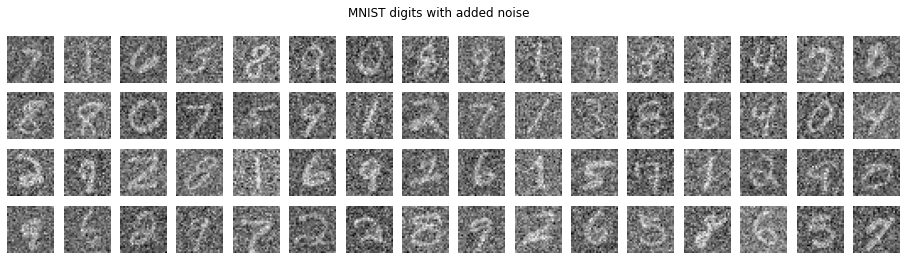

In [22]:
# plot the noisy examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))
noise = AdditiveGaussianNoise(plot=True)
for i, ax in enumerate(axarr.flat):
    ax.imshow(noise(images[i]).view(28, 28), cmap="binary_r")
    ax.axis("off")

plt.suptitle("MNIST digits with added noise")
plt.show()

### Train the denoising autoencoder

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 0.0008 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0007 =======


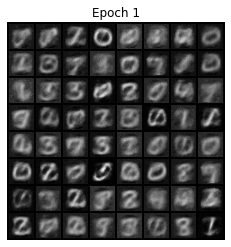

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 0.0005 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0006 =======


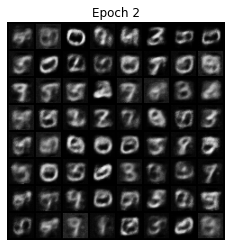

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 0.0004 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


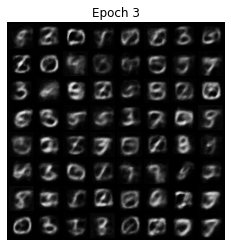

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 0.0004 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


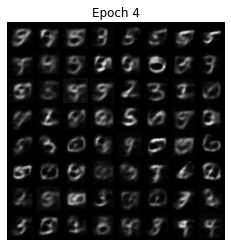

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 0.0004 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


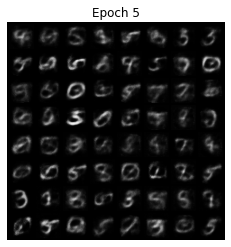

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 0.0004 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


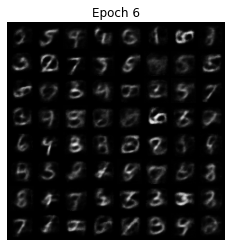

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 0.0004 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


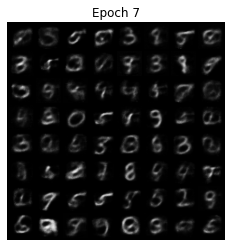

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


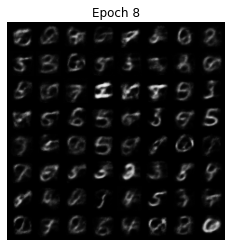

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


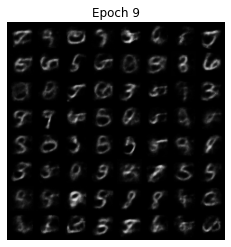

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0003 =======


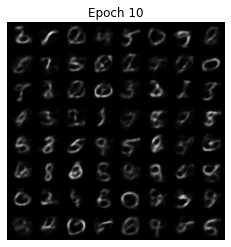

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


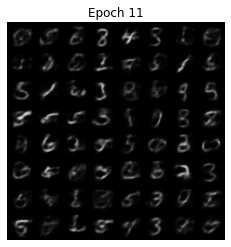

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


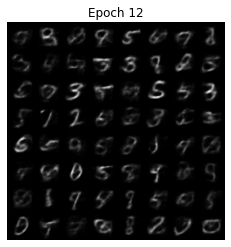

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


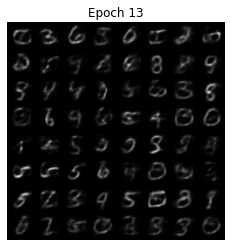

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


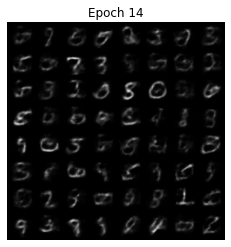

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


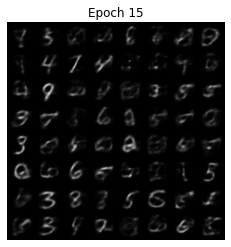

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


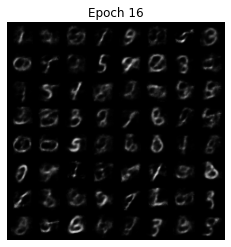

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


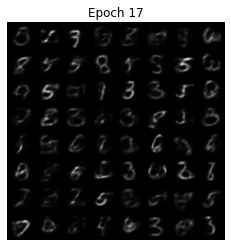

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


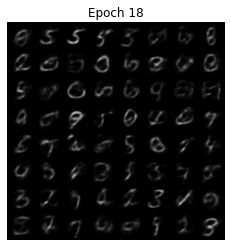

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0004 =======


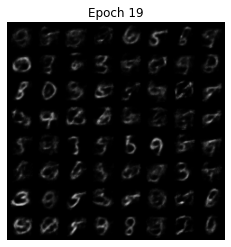

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


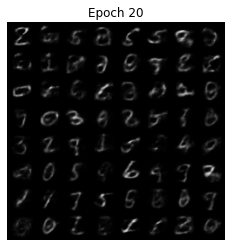

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


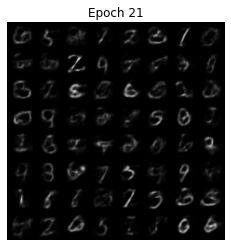

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


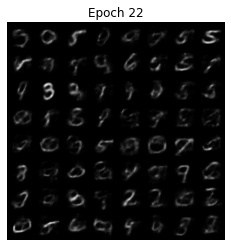

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


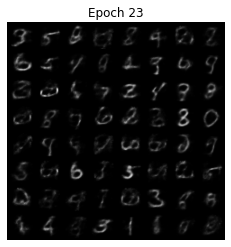

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


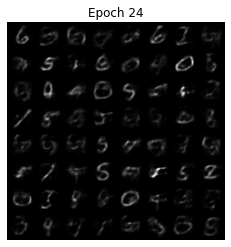

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 0.0003 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0005 =======


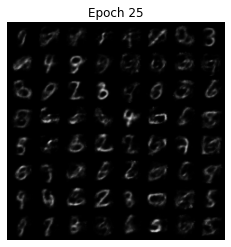

In [23]:
epochs = 25

train_loss_list = []
test_loss_list = []

for epoch in range(1, epochs + 1):
    ### =====TRAINING=====
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")
            data = data.to(device)

            """
            Calculate the loss for the current batch of inputs and 
            optimize the network parameters using the gradients.
            Variable `loss` should hold the loss value for current batch which 
            will be used to display the progress of training.
            """
            # loss = ...
            # YOUR CODE HERE
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_function(outputs["x_out"], data)
            loss.backward()
            optimizer.step()
            # raise NotImplementedError()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )
        train_loss_list.append(avg_epoch_loss)

    ### =====TESTING=====
    model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                """
                Calculate the loss for the current test batch of inputs.
                Variable `loss` should hold the test set loss value for current batch which 
                will be used to display the progress of training.
                """
                # test_loss = ...
                # YOUR CODE HERE
                outputs = model(data)
                loss = loss_function(outputs["x_out"], data)
                test_loss += loss.item()
                # raise NotImplementedError()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")
    test_loss_list.append(test_loss)

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

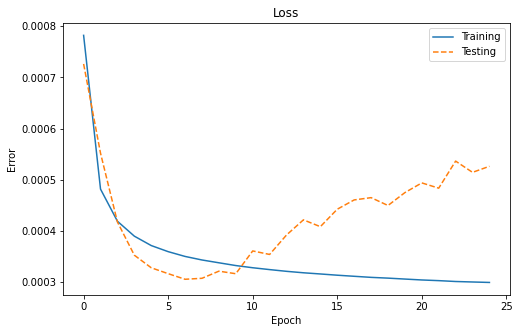

In [24]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(8, 5))

# Loss
ax = axarr
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

ax.plot(np.arange(epochs), train_loss_list)
ax.plot(np.arange(epochs), test_loss_list, linestyle="--")
ax.legend(["Training", "Testing"])

### Visualizing input data and its reconstruction from model

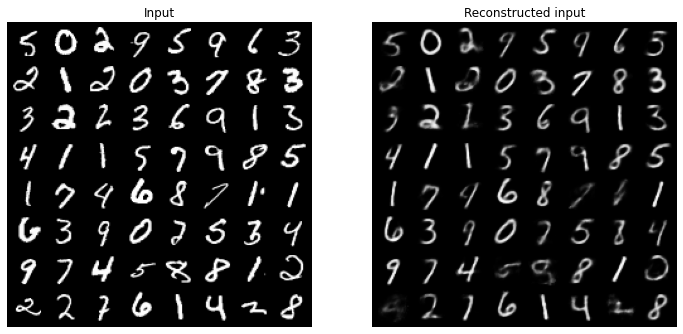

In [25]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

### Visualize the latent space embeddings

In [ ]:
# Increase the batch size for a nicer plot
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(model, dataloader)

# Variational AutoEncoder

Define a Variational Autoencoder by formulating the encoder to describe a probability distribution for each latent attribute. The latent dimension is characterized by mean and variance for each latent attribute.  

During the forward pass, you can use the `torch.chunk` function to split the latent layer to mean and variance vectors.  

Use the reparametrization trick suggested in the [VAE paper](https://arxiv.org/pdf/1312.6114.pdf) for sampling the latent dimension for input to the decoder.

In [26]:
# Define size of image features
# For MNIST data, we flatten the 28x28 image
num_input_features = 28**2


class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, num_latent_features):
        super().__init__(num_latent_features)
        """
        Modify the encoder network of `AutoEncoder` class to have 
        both mean and variance for each latent attribute.
        """
        # self.encoder = ...
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            # Input layer
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            # 1st hidden layer
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # Latent layer characterised by its mean and variance
            nn.Linear(in_features=128, out_features=2 * self.num_latent_features),
        )
        # raise NotImplementedError()

    def reparametrisation(self, mu, log_var):
        """
        Generate a sample from the latent distribution.

        Parameters
        ----------
        mu : array_like
             mean of the latent distribution.
        log_var : array_like
                  log of variance of the latent distribution.

        Returns
        -------
        sample : array_like
                 A sample latent representation.
        """
        # YOUR CODE HERE
        # This is needed because we can not backprob through a random node
        # N(mu, sigma) = mu + epsilon * sigma, where epsilon ~ N(0, 1)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample
        # raise NotImplementedError()

    def forward(self, x):
        outputs = {}

        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)

        z = self.reparametrisation(mu, log_var)

        # Run through decoder
        x = self.decoder(z)

        outputs["x_out"] = x
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var

        return outputs

In [27]:
num_latent_features = 10
model = VariationalAutoEncoder(num_latent_features).to(device)
print(model)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Construct the loss function

To ensure that the approximate learned distribution $q(z|x)$ is similar to $p(z|x)$, we minimize the KL divergence between the two distributions.  

$\min K L(q(z \mid x) \| p(z \mid x))$  

We can minimize the above expression by maximizing the following:  
$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

The first term represents the reconstruction likelihood and the second term ensures that our learned distribution $q$ is similar to the true prior distribution $p$. The KL-term can be calculated analytically and for the reconstruction error, $\log p(x|z)$, we can use the mean squared error.

In [30]:
def ELBO_loss(x_out, x, mu, log_var):
    """
    Calculate the ELBO loss for VAE.

    Parameters
    ----------
    x_out : array_like
            Output of the decoder network.
    x : array_like
        Input to the decoder network.
    mu : array_like
         Mean of the latent distribution.
    log_var : array_like
              Log of variance of the latent distribution.
    Returns
    -------
    loss : array_like
           Calculated ELBO loss.
    """
    # YOUR CODE HERE
    MSE = mse_loss(x_out, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = MSE + KLD
    return loss
    # raise NotImplementedError()


"""Define the optimizer parameters"""
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = ELBO_loss

### Train the model

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 45.3015 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 36.4346 =======


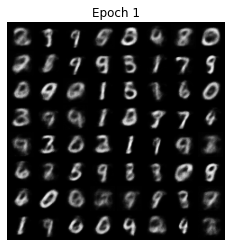

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 34.6488 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 33.1668 =======


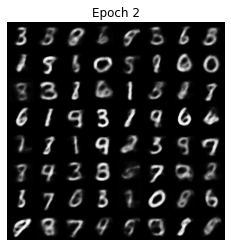

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 32.6524 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 31.8273 =======


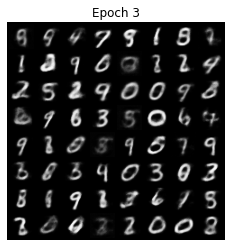

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 31.5996 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 31.2986 =======


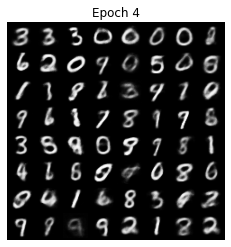

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 30.9126 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 30.7001 =======


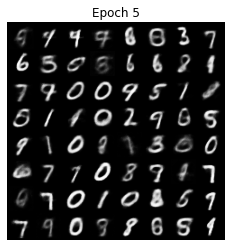

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 30.4383 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 30.0662 =======


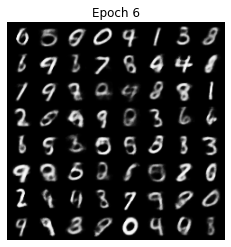

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 30.0886 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 30.0268 =======


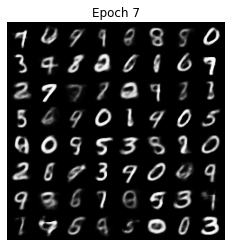

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 29.8045 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 29.6462 =======


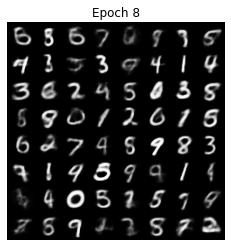

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 29.5914 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 29.5056 =======


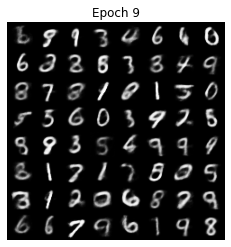

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 29.3989 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 29.3309 =======


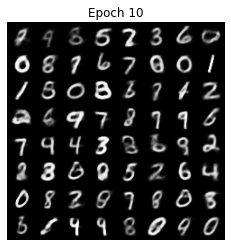

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 29.2524 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 29.3240 =======


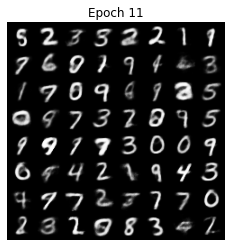

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 29.1024 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 29.0340 =======


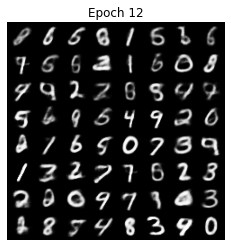

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 28.9895 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.9409 =======


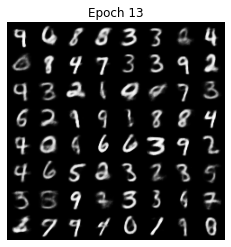

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 28.8591 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.8348 =======


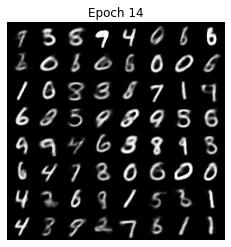

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 28.7634 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.8224 =======


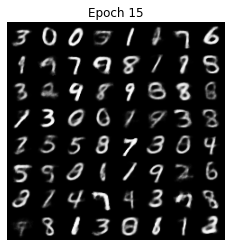

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 28.6885 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.7081 =======


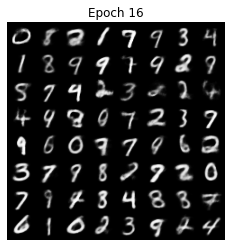

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 28.5890 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.6948 =======


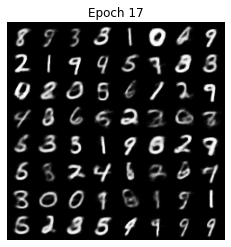

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 28.5495 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.5530 =======


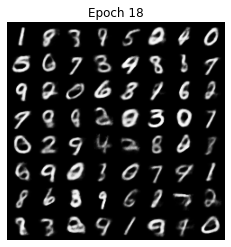

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 28.4700 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.9172 =======


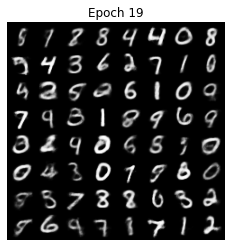

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 28.4153 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.4992 =======


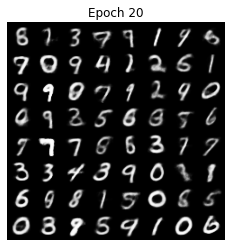

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 28.3691 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.5521 =======


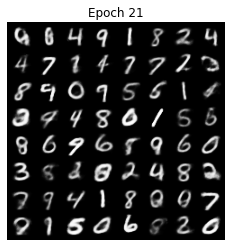

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 28.2986 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.4297 =======


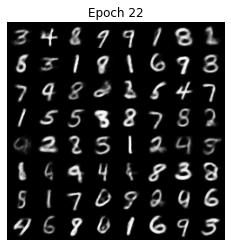

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 28.2723 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.4498 =======


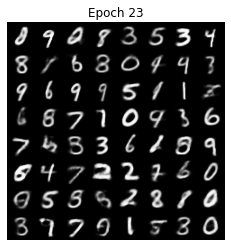

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 28.2304 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.3354 =======


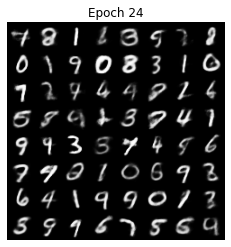

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 28.1734 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 28.1968 =======


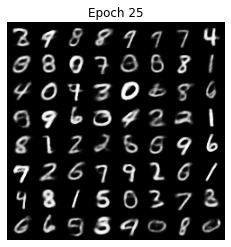

In [31]:
epochs = 25

for epoch in range(1, epochs + 1):
    ### =====TRAINING=====
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")
            data = data.to(device)

            """
            Calculate the loss for the current batch of inputs and 
            optimize the network parameters using the gradients.
            Variable `loss` should hold the loss value for current batch which 
            will be used to display the progress of training.
            """
            # loss = ...
            # YOUR CODE HERE
            optimizer.zero_grad()
            outputs = model(data)
            loss = ELBO_loss(
                outputs["x_out"], data, outputs["mu"], outputs["log_var"]
            )
            loss.backward()
            optimizer.step()
            # raise NotImplementedError()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )

    ### =====TESTING=====
    model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                """
                Calculate the loss for the current test batch of inputs.
                Variable `loss` should hold the test set loss value for current batch which 
                will be used to display the progress of training.
                """
                # test_loss = ...
                # YOUR CODE HERE
                outputs = model(data)
                loss = ELBO_loss(
                    outputs["x_out"], data, outputs["mu"], outputs["log_var"]
                )
                test_loss += loss.item()
                # raise NotImplementedError()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

### Plot the training loss values

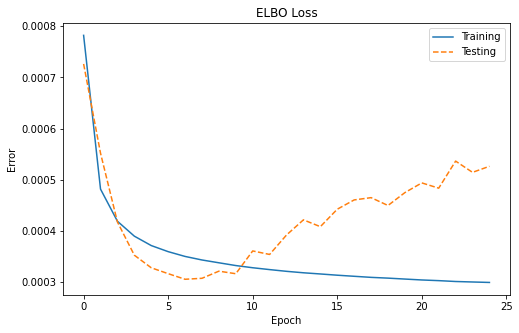

In [32]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(8, 5))

# Loss
ax = axarr
ax.set_title("ELBO Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

ax.plot(np.arange(epochs), train_loss_list)
ax.plot(np.arange(epochs), test_loss_list, linestyle="--")
ax.legend(["Training", "Testing"])

### Visualizing input data and its reconstruction from model

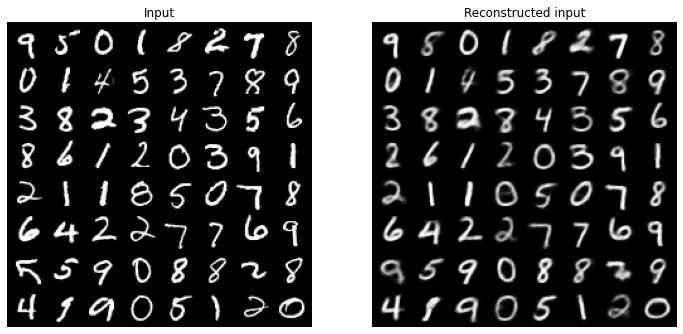

In [33]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

### Visualize the embeddings

In [ ]:
# Increase the batch size for a nicer plot
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(model, dataloader)